# Deep Learning to Clone Driving Behavior

In this project we will Train a deep neural network to drive a car like us!

The goal is to drive a car autonomously in a simulator using a deep neural network trained on human driving behavior. Udacity has provided a simulator and a python script ([drive.py](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/585b1df0_drive/drive.py)) that connects our DNN with the simulator. The simulator has two modes. In the "training mode" on track-1 the car can be controlled through a keyboard to generate training data. Training data consists of images captured by three cameras mounted on the car and corresponding steering angle. A model is trained on the training data that can be used to predict steering angles while driving on unseen track-2 in simulator. 

## Prologue

I'm a student of November, 2016 cohort. My guess is most of the submissions for this project coming in these days must be from October cohort, not November. Being a student of later cohort gave me two advantages. First, Udacity has published a helpful guide with some hints and advice [here](https://carnd-udacity.atlassian.net/wiki/questions/26214464/answers/26215455). Second, based on feedback from earlier cohort, Udacity has provided sample data for track 1 [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip).

Although, I drove the car around on track-1 to get a feel of problem faced by October students who did not have a joystick or a steering wheel, I knew I'll end up using the sample data provided by Udacity. This itself must have saved me about a week worth of time. Thank you Dhruv and team! One problem solved for me. 

I also gathered from the above wiki guide that lot of students are struggling because they don't have adequate GPU hardware. Udacity has provided $50 credit for AWS. This is very generous of Udacity. Thank you David and team! I too don't have a powerful machine to iterate my ideas on. After having spent an "obscene amount" on AWS for past experiments, I refused to spend a dime on AWS for this project. This created a new challenge for me.

Student comments on the same wiki indicated that there are two kinds of students in the class. There are few students who are either Genius or have a prior background in the field. Most of the students are new to the subject and are really working hard to learn.

## Problem Statement

*So I took upon myself to find a solution that will be extremely light weight. It should not require any powerful GPU machine or Amazon EC2 instance. It should run easily on my 2012 MBP with 8 GB memory. Yet it should be fast. Each epoch should not take more than 2mins. Also, for the design and model architecture, I refused to entertain any idea or concept that were not taught in the class. Although, I do assume that you have atleast taken "Intro to Machine Learning" class. It should be a required prerequisite IMHO.*

## Let's begin!

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import shutil
import os
import random
import cv2
import math
import json
#import seaborn as sns 

import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Lambda, ELU
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from IPython.display import display # Allows the use of display() for DataFrames

# Visualizations will be shown in the notebook.
%matplotlib inline

# # init seaborn
# paper_rc = {'lines.linewidth': 1, 'lines.markersize': 1}                  
# sns.set_context("paper", font_scale=1.0, rc = paper_rc)
# sns.set_style(style='white') 
# husl_color = sns.color_palette("husl", n_colors=100, desat=0.75)

## Loading Dataset

We are using only sample data for track 1 provided by Udacity. Nothing more. It can be downloaded from [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

The dataset is stored in 'driving_log.csv' file. This file has pointers to the camera image files on the disk and corresponding steering angles.

Let us load the dataset and analyze its contents.

In [46]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv('driving_log.csv', names=columns)

print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")

print("Data loaded...")

Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (8036, 7) 

       steering_angle     throttle        brake        speed
count     8036.000000  8036.000000  8036.000000  8036.000000
mean         0.004070     0.869660     0.001970    28.169839
std          0.128840     0.301326     0.036565     6.149327
min         -0.942695     0.000000     0.000000     0.502490
25%          0.000000     0.985533     0.000000    30.183093
50%          0.000000     0.985533     0.000000    30.186400
75%          0.000000     0.985533     0.000000    30.186640
max          1.000000     0.985533     1.000000    30.709360 

Data loaded...


## Exploring Dataset

Let us analyze the loaded dataset. 

We are particularly interested in the steering angle attribute. Let us plot the histogram of steering angles.

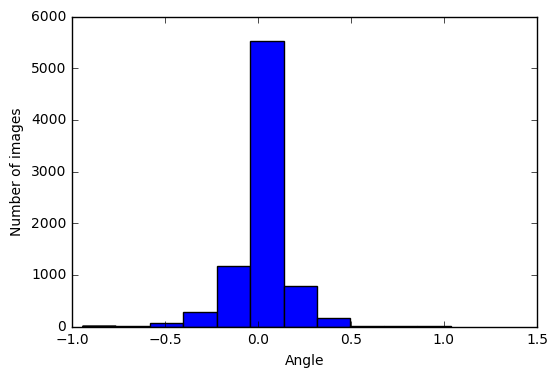

In [47]:
binwidth = 0.18

# histogram before image augmentation
#lt.hist(data.steering_angle,.5)
plt.hist(data.steering_angle,bins=np.arange(min(data.steering_angle), max(data.steering_angle) + binwidth, binwidth))
plt.xlabel('Angle')
plt.ylabel('Number of images')
plt.show()

Oh boy! We have a very biased dataset in our hands here. We have tons of samples for steering angle 0.0 compared to all other steering angles combined. This is quite understandable as steering angle 0.0 corresponds to car going straight. During the "training mode" in track-1 most of the road is straight with occassional curves and turns. There isn't enough samples in the training dataset for non-zero steering angles. If we train our car with this dataset, it will surely learn just to drive straight and never (or struggle) to make turns.  

To fix the dataset bias problem, Machine Learning concepts teach us to try following:

- Get More Data
- Invent More Data

*Get More Data* will put us back in the square one, which will require us to own a joystick and spend hours collecting and cleaning data. So we will avoid this approach.

*Invent More Data* means, if your data are vectors of numbers, create randomly modified versions of existing vectors. If your data are images, create randomly modified versions of existing images. If your data are text, you get the idea... Often this is called data augmentation or data generation. 

Augmentation refers to the process of generating new training data from a smaller dataset such that the new dataset represents the real world data one may see in practice. A typical convolutional neural network can have up to a million parameters, and tuning these parameters requires millions of training instances of *uncorrelated data*. 
For our car example, this will require us to drive (or generate images) the car under different weather, lighting, traffic and road conditions. As you will soon see, the easist way to achieve this is to use **image augmentation**. 

## Data Partitioning

Let us shuffle and split our dataset into two parts: Training data and Validation data. Since we need lots of training data we will keep aside 90% of the data for training and remaining for validation.

We are not setting aside any Test data here because real test of the model is actually driving on the track. 

In [48]:
# Get randomized datasets for training and validation

# shuffle data
data = data.reindex(np.random.permutation(data.index))

num_train = int((len(data) / 10.) * 9.)

X_train = data.iloc[:num_train]
X_validation = data.iloc[num_train:]

print("X_train has {} elements.".format(len(X_train)))
print("X_valid has {} elements.".format(len(X_validation)))

X_train has 7232 elements.
X_valid has 804 elements.


## Configurable Variables

These are all the configurable variables in our program:

In [49]:
# image augmentation variables
CAMERA_OFFSET = 0.25
CHANNEL_SHIFT_RANGE = 0.2
WIDTH_SHIFT_RANGE = 100
HEIGHT_SHIFT_RANGE = 40

# processed image variables
PROCESSED_IMG_COLS = 64
PROCESSED_IMG_ROWS = 64
PROCESSED_IMG_CHANNELS = 3

# model training variables
NB_EPOCH = 3
BATCH_SIZE = 256

- *CAMERA_OFFSET:* Our car has three cameras. Center, Left, and Right. We will utilize images from all three cameras so we can generate additional training data to simulate recovery. We will add a small angle .25 to the left camera and subtract a small angle of 0.25 from the right camera. The main idea being the left camera has to move right to get to center, and right camera has to move left.


- *CHANNEL_SHIFT_RANGE:* One of the tricks in augmenting an image is to shift its color channel by a small fraction. We will randomly shift input images in the range [-0.2, 0.2]


- *WIDTH_SHIFT_RANGE:* Shifting the input image horizontally by a small fraction is another technique in image augmentation. We will randomly shift input images in the range [-100, 100]


- *HEIGHT_SHIFT_RANGE:* Similarly input image can be shifted vertically by a small fraction. We will randomly shift vertically in the range [-40, 40]


- *PROCESSED_IMG_COLS:* Final step in our image augmentation process is Croping and Resizing. We have chosen to train our model on 64x64 pixel images. Hence height of the processed image will be 64px.


- *PROCESSED_IMG_ROWS:* Width of the processed image will be 64px.


- *PROCESSED_IMG_CHANNELS:* We have chosen to work with color images to train our model. Hence processed image will have 3 channels.


- *NB_EPOCH:* Our DNN will be trained for 8 epochs.


- *BATCH_SIZE:* In order to keep the memory footprint of the program low, we will augment and process images in batches of 256.

## Image Augmentation Functions

As noted earlier, we will generate new training data from a smaller dataset for under represented steering angles by a technique called Image Augmentation.

We will use following 7 augmentation functions in our image processing pipeline:

- horizontal_flip
- channel_shift
- height_shift
- width_shift
- brightness_shift
- crop_image
- resize_image

In [50]:
# flip images horizontally
def horizontal_flip(img, steering_angle):
    flipped_image = cv2.flip(img, 1)
    steering_angle = -1 * steering_angle
    return flipped_image, steering_angle

This function flips the input image horizontally using OpenCV apis. In doing so it appropriately reverses the sign of the steering angle to reflect the transformation.

In [51]:
# shift range for each channels
def channel_shift(img, channel_shift_range=CHANNEL_SHIFT_RANGE):
    img_channel_index = 2 # tf indexing
    channel_shifted_image = random_channel_shift(img, channel_shift_range, img_channel_index)
    return channel_shifted_image

One of the tricks in augmenting an image is to shift its color channel by a small fraction. This function randomly shifts input image channel in the range [-0.2, 0.2] by using keras image processing apis. Steering angle does not change after this transformation.

In [52]:
# shift height/width of the image by a small fraction
def height_width_shift(img, steering_angle):
    rows, cols, channels = img.shape
    
    # Translation
    tx = WIDTH_SHIFT_RANGE * np.random.uniform() - WIDTH_SHIFT_RANGE / 2
    ty = HEIGHT_SHIFT_RANGE * np.random.uniform() - HEIGHT_SHIFT_RANGE / 2
    steering_angle = steering_angle + tx / WIDTH_SHIFT_RANGE * 2 * .2
    
    transform_matrix = np.float32([[1, 0, tx],
                                   [0, 1, ty]])
    
    translated_image = cv2.warpAffine(img, transform_matrix, (cols, rows))
    return translated_image, steering_angle

Shifting the input image horizontally and vertically by a small fraction is another technique in image augmentation. This function randomly shifts images both vertically and horizontally in the given range by using OpenCV apis. A new steering angle is also calculated to match the transformation.

In [53]:
def brightness_shift(img, bright_value=None):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if bright_value:
        img[:,:,2] += bright_value
    else:
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

This function randomly changes the brightness (or darkness) of the input image using OpenCV apis. Steering angle does not change after this transformation.

In [54]:
# crop the top 1/5 of the image to remove the horizon and the bottom 25 pixels to remove the car’s hood
def crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (PROCESSED_IMG_COLS, PROCESSED_IMG_ROWS), interpolation=cv2.INTER_AREA)    
    return img

This function will crop the top 1/5 of the image to remove the horizon and the bottom 25 pixels to remove the car’s hood. Steering angle does not change after this transformation.

In [55]:
def apply_random_transformation(img, steering_angle):
    
    transformed_image, steering_angle = height_width_shift(img, steering_angle)
    transformed_image = brightness_shift(transformed_image)
    # transformed_image = channel_shift(transformed_image) # increasing train time. not much benefit. commented
    
    if np.random.random() < 0.5:
        transformed_image, steering_angle = horizontal_flip(transformed_image, steering_angle)
            
    transformed_image = crop_resize_image(transformed_image)
    
    return transformed_image, steering_angle

This is the wrapper function which makes use of all the previous transformations to augment an image. This function is directly used in the program.

## Showcase: Image Augmentation 

Let us now see all the image transformation functions in action. Here we take an image and apply all the transformations to it. The ouput of the transformation is plotted below. 

At the bottom of each transformed image, we have noted the name of the transformation function and corresponding steering angle change (if any).

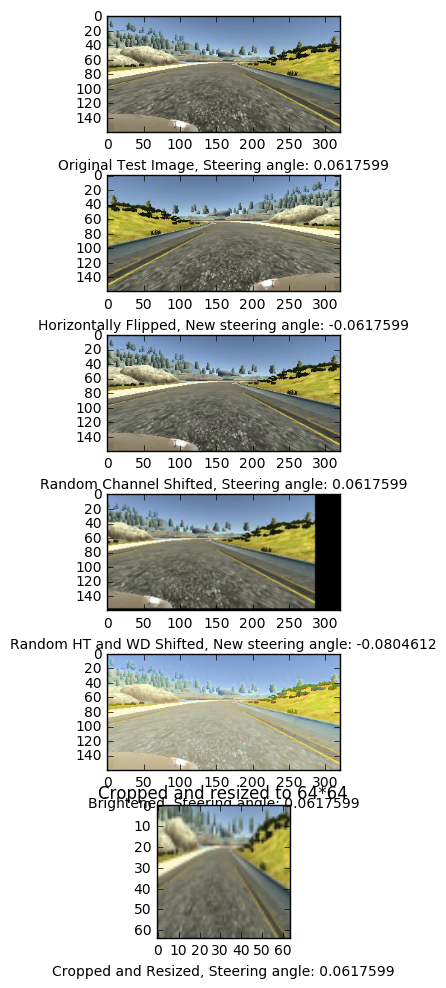

In [74]:
def read_image(fn):
    img = load_img(fn)
    img = img_to_array(img) 
    return img

test_fn = "IMG/right_2016_12_01_13_46_36_972.jpg"
steering_angle = 0.0617599

test_image = read_image(test_fn)

plt.subplots(figsize=(3, 12))

# original image
plt.subplot(611)
plt.xlabel("Original Test Image, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(test_image))

# horizontal flip augmentation
flipped_image, new_steering_angle = horizontal_flip(test_image, steering_angle)
plt.subplot(612)
plt.xlabel("Horizontally Flipped, New steering angle: " + str(new_steering_angle))
plt.imshow(array_to_img(flipped_image))

# channel shift augmentation
channel_shifted_image = channel_shift(test_image, 2)
plt.subplot(613)
plt.xlabel("Random Channel Shifted, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(channel_shifted_image))

# width shift augmentation
width_shifted_image, new_steering_angle = height_width_shift(test_image, steering_angle)
new_steering_angle = "{:.7f}".format(new_steering_angle)
plt.subplot(614)
plt.xlabel("Random HT and WD Shifted, New steering angle: " + str(new_steering_angle))
plt.imshow(array_to_img(width_shifted_image))

# brightened image
brightened_image = brightness_shift(test_image, 255)
plt.subplot(615)
plt.xlabel("Brightened, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(brightened_image))

# crop augmentation
cropped_image = crop_resize_image(test_image)
plt.subplot(616)
plt.title("Cropped and resized to 64*64")
plt.xlabel("Cropped and Resized, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(cropped_image))

## Keras generator for subsampling

As there was limited data and we are generating thousands of training examples from the same image, it is not possible to store all the images into memory. We will utilize kera’s generator function to sample images such that images with lower angles have lower probability of getting represented in the dataset. This alleviates any problems we may ecounter due to model having a bias towards driving straight. 

Given a line from csv file, this function randomly loads center or left or right image. Applies all appropriate image augmentation functions to it and return augmented image and transformed steering angle. This function is directly used in Keras generator function below.

In [56]:
def load_and_augment_image(line_data):
    i = np.random.randint(3)
    
    if (i == 0):
        path_file = line_data['left'][0].strip()
        shift_angle = CAMERA_OFFSET
    elif (i == 1):
        path_file = line_data['center'][0].strip()
        shift_angle = 0.
    elif (i == 2):
        path_file = line_data['right'][0].strip()
        shift_angle = -CAMERA_OFFSET
        
    steering_angle = line_data['steering_angle'][0] + shift_angle
    
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, steering_angle = apply_random_transformation(img, steering_angle)
    return img, steering_angle

It turns out that Keras generator, actually any python generator, is **not thread-safe** in multi-threaded application. Solution is to wrap our iterator/generator in a thread safe class such as one below. You can read about python iterator/generator thread safety [here](http://anandology.com/blog/using-iterators-and-generators/)

In [57]:
# generators in multi-threaded applications is not thread-safe. Hence below:
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()
        
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

Finally, the keras generator is presented below. It generates batches of augmented images on-the-fly from the limited dataset that Udacity provided. You can get more intutiton about Keras generators [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

The ‘threshold’ variable is a threshold that determines if a data with small angle will be dropped or not.

In [58]:
generated_steering_angles = []
threshold = 1

@threadsafe_generator
def generate_batch_data(_data, batch_size = 32):
    
    batch_images = np.zeros((batch_size, PROCESSED_IMG_ROWS, PROCESSED_IMG_COLS, PROCESSED_IMG_CHANNELS))
    batch_steering = np.zeros(batch_size)
    
    while 1:
        for batch_index in range(batch_size):
            row_index = np.random.randint(len(_data))
            line_data = _data.iloc[[row_index]].reset_index()
            
            # idea borrowed from Vivek Yadav: Sample images such that images with lower angles 
            # have lower probability of getting represented in the dataset. This alleviates 
            # any problems we may ecounter due to model having a bias towards driving straight.
            
            keep = 0
            while keep == 0:
                x, y = load_and_augment_image(line_data)
                if abs(y) < .1:
                    val = np.random.uniform()
                    if val > threshold:
                        keep = 1
                else:
                    keep = 1
            
            batch_images[batch_index] = x
            batch_steering[batch_index] = y
            generated_steering_angles.append(y)
        yield batch_images, batch_steering

## Examples of generated images

Now let us look at few augmented images generated by our image processing pipeline.

Quite evidently you will notice that all processed images have 'road' clearly visible and is front and center. These images will be fed to a Deep Neural Network as training images. Just by looking at the quality of these images, we have good confidence that our Network will train well. 

Let us keep our fingers crossed ;)

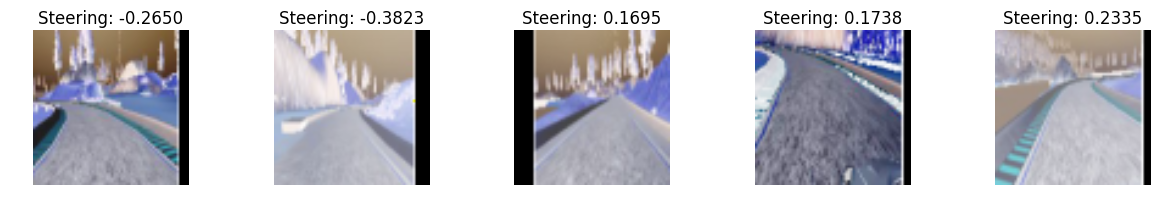

In [59]:
iterator = generate_batch_data(X_train, batch_size=5)
sample_images, sample_steerings = iterator.__next__()

plt.subplots(figsize=(15, 2))
for i, img in enumerate(sample_images):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title("Steering: {:.4f}".format(sample_steerings[i]))
    plt.imshow(img)
plt.show()

## Model Architecture and training

Multiple training architectures based on Convolutional Neural Networks were evaluated. Most of them failed. Many had partial success. Given more time tuning the hyperparameters and architecture we could have made them to work. Transfer learning with VGG16 was also attempted. These networks were used by removing the final layers and replacing them with our own fully connected and convolutional layers. However, these were rejected because of their size and our requirement to find a light weight solution. 

Finally, it was a toss up between [nVIDIA model](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) and [comma.ai](https://github.com/commaai/research/blob/master/train_steering_model.py) model. I tried both the models and both of them work equally well. In the end, I chose to work further with comma.ai model as it came with indirect recommendation from Dhruv himself in the above wiki guide :)

Comma.ai model is small in size and hence low processing latency. Our network structure can be summarized as follows:

- A normalization layer on the top of the network to normalize the input images.
- Convolutional layer, 16 feature maps with a size of 8×8, an Exponential Linear Unit(elu) activation function.
- Convolutional layer, 32 feature maps with a size of 5×5, an elu activation function.
- Convolutional layer, 64 feature maps with a size of 5×5, an elu activation function.
- Flatten layer.
- Dropout set to 20%.
- ELU non-linearity layer
- Fully connected layer with 512 units and a elu activation function.
- Dropout set to 50%.
- ELU non-linearity layer
- Fully connected output layer with 1 unit and no activation function as this is a regression problem, not classification.

A 'mean_squared_error' loss function is used with Adam optimization algorithm configured with a learning rate of 0.0001. This learning rate was selected after bit of trial and error. With larger learning rates (0.1 and 0.001), car was making abrupt steering angle changes, causing bumpy ride.

### Training Strategy

The dataset obtained from Udacity consisted of image files and a CSV file. The CSV file was loaded into a pandas dataframe, shuffled and then split into Training data and Validation data. 

An image generator that takes the pandas dataframe as input and generates batches of training data is developed. This can be seen in the 'generate_batch_data' method in the notebook. The dataset was augmented by also using the right and left camera images with a 0.25 degree shift to the original steering angle. The input images were augmented with various techniques such as Horizontal-Flip, Height-Width shift, Color-channel shift, Brightness shift etc. Images were then cropped out. The region of interest starts under the horizon, removes most of the exterior environment and focuses on the road. This is similar to what was done in the NVIDIA model. The image was then resized to 64 × 64 before being passed into the model.

The ADAM optimizer with a learning rate of 0.0001 is used. The data is trained over 8 epochs of ~20000 samples each.

## comma.ai model

comma.ai model is implemented [here](https://github.com/commaai/research/blob/master/train_steering_model.py) in github. The structure of the model was well discussed above.

In [60]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(PROCESSED_IMG_ROWS, PROCESSED_IMG_COLS, PROCESSED_IMG_CHANNELS)))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation='elu', name='Conv1'))
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv2'))
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv3'))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512, activation='elu', name='FC1'))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1, name='output'))
model.summary()

# compile
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='mse', metrics=[])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 64, 64, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 16, 16, 16)    3088        lambda_2[0][0]                   
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 8, 8, 32)      12832       Conv1[0][0]                      
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 4, 4, 64)      51264       Conv2[0][0]                      
___________________________________________________________________________________________

## Model Visualization

Thanks to Keras visualization utility, following is the pictorial representation of our model. As you can see, it is a very simple DNN, which is what we set out to find in our 'problem definition'.

In [61]:
# from keras.utils.visualize_util import plot

# plot(model, to_file='model.png', show_shapes=True)

# # img = read_image('model.png')

# # # original image
# # plt.subplots(figsize=(5,10))
# # plt.subplot(111)
# # plt.axis('off')
# # plt.imshow(array_to_img(img))

## Model Fitting

One of the key strategies of this solution is to - sample images such that images with lower angles have lower probability of getting represented in the dataset. This alleviates any problems we may ecounter due to model having a bias towards driving straight. The ‘threshold’ variable is a threshold that determines if a data with small angle will be dropped or not. Its value should be progressively reduced as model training continues, so that small amount of lower steering angles are also learned by the model. The value of 'threshold' is reduced in the 'on_epoch_end' callback as shown below. 

In [62]:
class LifecycleCallback(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        global threshold
        threshold = 1 / (epoch + 1)

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_train_end(self, logs={}):
        print('END TRAINING')
        
# Calculate the correct number of samples per epoch based on batch size
def calc_samples_per_epoch(array_size, batch_size):
    num_batches = array_size / batch_size
    samples_per_epoch = math.ceil(num_batches)
    samples_per_epoch = samples_per_epoch * batch_size
    return samples_per_epoch

### Let the training begin!

In [63]:
lifecycle_callback = LifecycleCallback()       

train_generator = generate_batch_data(X_train, BATCH_SIZE)
validation_generator = generate_batch_data(X_validation, BATCH_SIZE)

samples_per_epoch = calc_samples_per_epoch((len(X_train)*3), BATCH_SIZE)
nb_val_samples = calc_samples_per_epoch((len(X_validation)*3), BATCH_SIZE)

history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              samples_per_epoch = samples_per_epoch, 
                              nb_val_samples = nb_val_samples,
                              nb_epoch = NB_EPOCH, verbose=1,
                              callbacks=[lifecycle_callback])

BEGIN TRAINING
Epoch 1/3
21760/21760 [==============================] - 117s - loss: 0.0701 - val_loss: 0.0617
Epoch 2/3
21760/21760 [==============================] - 102s - loss: 0.0593 - val_loss: 0.0540
Epoch 3/3
21760/21760 [==============================] - 96s - loss: 0.0506 - val_loss: 0.0468
END TRAINING


## Conclusion

An important observation here is that the average time taken by each Epoch is only 1.7mins on a plain 2012 MBP. No fancy hardware. No intricate concepts at play here.

So we have achieved our goal of finding a DNN model that can be trained on vanilla hardware without compromising on the quality or training time. Hurray!

## Save Model

In [64]:
model_json = model.to_json()
with open("./model.json", "w") as json_file:
    json.dump(model_json, json_file)
model.save_weights("./model.h5")
print("Saved model to disk")

Saved model to disk


## Analysis

At the begining of the project we plotted a histogram of 'steering angles' and found that there were too many samples with 0.0 angle. We noted then that, in order to teach our car to take turns, we have to generate lot of new images with non-zero angles by augmentation. 

Let us now look at what kinds of images (and corresponding steering angles) were fed into our model during training. We can do so by plotting a histogram of generated images.

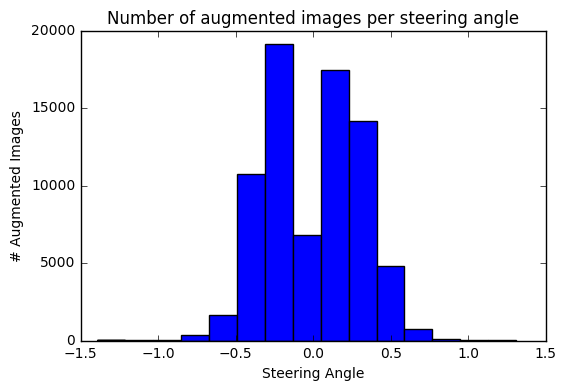

In [65]:
plt.hist(generated_steering_angles, bins=np.arange(min(generated_steering_angles), max(generated_steering_angles) + binwidth, binwidth))
plt.title('Number of augmented images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Augmented Images')
plt.show()

Bingo! The number of augmented images for non-zero steering angles are far more than for 0.0 angle. With this training data, our car is bound to not only learn to drive straight but also to drive curves and turns.

## Plots

Let us now look at 'model loss' plot. 

dict_keys(['loss', 'val_loss'])


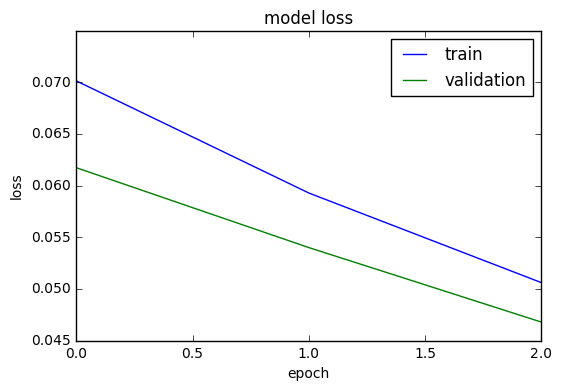

In [66]:
# list all data in history
print(history.history.keys())

# summarize history for epoch loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

As seen in the above plot, both Training and Validation Loss systematically dropped our 8 training epochs. This is a clear sign that our model has NOT overfitted the data and has generalized well. Hopefully it will work well for new and unseen data (new driving track in our project).

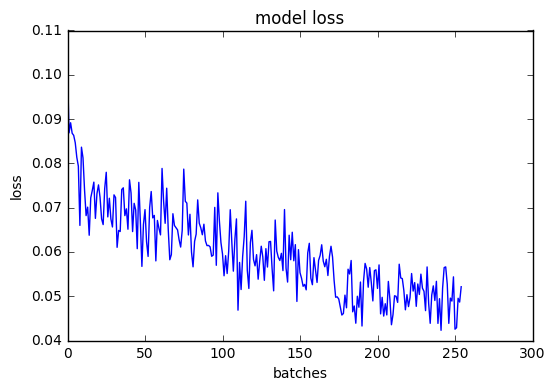

In [67]:
# summarize history for batch loss
batch_history = lifecycle_callback.losses
plt.plot(batch_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()

Similarly, as seen in the above plot, model's cost decreased as the training progessed, indicating that model improved with more training data.

## Some layer visualizations

Just for fun, let us now peer into our Neural Model to understand how it learns to drive!

In [68]:
# Layer visualizations

test_fn = "IMG/center_2016_12_01_13_32_43_457.jpg"

def visualize_model_layer_output(layer_name):
    model2 = Model(input=model.input, output=model.get_layer(layer_name).output)

    img = load_img(test_fn)
    img = crop_resize_image(img_to_array(img))
    img = np.expand_dims(img, axis=0)

    conv_features = model2.predict(img)
    print("conv features shape: ", conv_features.shape)
    
    # plot features
    plt.subplots(figsize=(5, 5))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.axis('off')
        plt.imshow(conv_features[0,:,:,i], cmap='gray')
    plt.show()

conv features shape:  (1, 16, 16, 16)


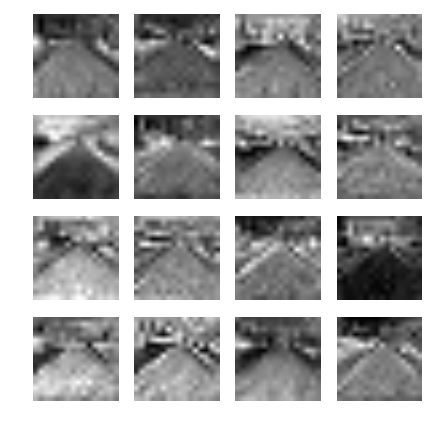

In [69]:
visualize_model_layer_output('Conv1')

These are some of the feature map plots after first convolution layer. As you can see model has detected simple features such as edges and straight lines at this point. You can actually see the road ahead in all the feature map.

conv features shape:  (1, 8, 8, 32)


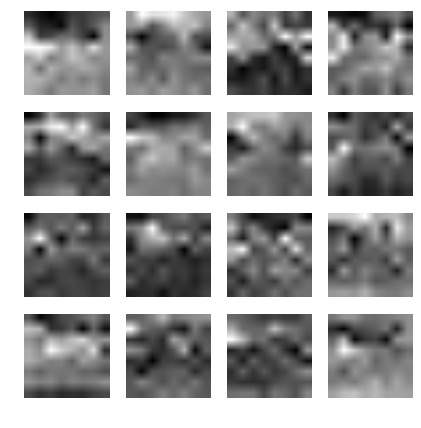

In [70]:
visualize_model_layer_output('Conv2')

These are feature map plots after second convolution layer. These features are higher level feature learnt from previous layer's output. At this point it is hard to decipher what Neural Network is doing.

## The Final Test

The best test for the model is to actually let the car drive autonomously on both Training and Test (unseen) tracks. Let us see how our model did in these recorded videos.

### Track 1

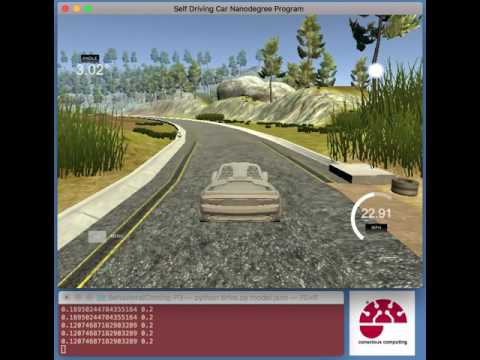

In [71]:
from IPython.display import YouTubeVideo
YouTubeVideo('mYejcv8uDkw')

### Track 2

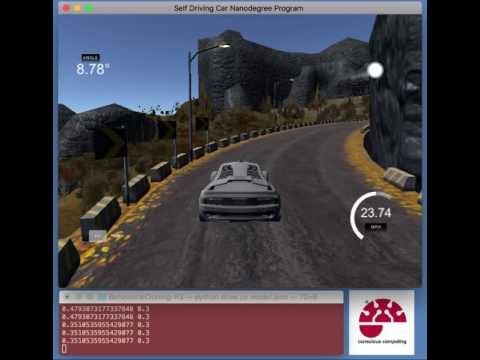

In [72]:
YouTubeVideo('TlTQVpRr6N8')